(batt_life_sim)=
# Battery Life Simulation
This tutorial demonstrates estimation of how long a system can operate from a battery. `sysLoss` does not include battery models as such but can interface with user supplied battery models using callback functions. We will revisit the Bluetooth sensor from the first tutorial and evaluate the battery life with different battery models.

In [1]:
# This cell can be removed, it is only used for running the notebook during Sphinx documentation build.
import sys, os
if os.getcwd().replace('\\', '/').endswith("/docs/nb"):
    sys.path.insert(0, os.path.abspath(os.path.join("../../src")))

In [2]:
from sysloss.components import *
from sysloss.system import System
import numpy as np
import matplotlib.pyplot as plt

## System definition
The Bluetooth Sensor System is reused, including load phases, with the addition of 2D interpolation data for converter efficiency. The system is powered by a rechargeable lithium battery with a capacity of 156mAh and nominal voltage of 3.6V. Battery voltage varies a lot depending on state-of-charge (SOC), so converter efficiencies should reflect this.

In [3]:
CAPACITY = .156 # battery capacity in Ah
VNOMINAL = 3.6 # nominal battery voltage (V)
buck_eff = {"vi": [3.0, 5.0], "io": [1e-6, 1e-5, 1e-4, 1e-3, 1e-2], "eff": [[0.72, 0.89, 0.92, 0.925, 0.93],[0.65, 0.84, 0.87, 0.9, 0.91]]}
boost_eff = {"vi": [3.0, 4.5], "io": [1e-6, 1e-5, 1e-4, 1e-3, 1e-2], "eff": [[0.55, 0.65, 0.72, 0.8, 0.85],[0.62, 0.72, 0.81, 0.85, 0.91]]}
bts = System("Bluetooth sensor", Source("LiPo battery", vo=VNOMINAL, rs=0.0))
bts.add_comp("LiPo battery", comp=Converter("Buck 1.8V", vo=1.8, eff=buck_eff))
bts.add_comp("Buck 1.8V", comp=PLoad("MCU", pwr=13e-3))
bts.add_comp("LiPo battery", comp=Converter("Boost 5V", vo=5.0, eff=boost_eff, iis=3e-6))
bts.add_comp("Boost 5V", comp=RLoss("RC filter", rs=6.8))
bts.add_comp("RC filter", comp=ILoad("Sensor", ii=6e-3))
bts_phases = {"sleep": 3600, "acquire": 2.5, "transmit": 2e-3}
bts.set_sys_phases(bts_phases)
bts.set_comp_phases("Boost 5V", phase_conf=["acquire"])
mcu_pwr = {"sleep": 12e-6, "acquire": 15e-3, "transmit": 35e-3}
bts.set_comp_phases("MCU", phase_conf=mcu_pwr)

## Ideal battery
We start with an ideal battery. Although not invented yet, it has a constant output voltage and zero internal resistance. The battery life is then simply the battery capacity divided by average system current.

In [4]:
bdf = bts.solve()
bdf.tail()

,Component,Type,Parent,Phase,Vin (V),Vout (V),Iin (A),Iout (A),Power (W),Loss (W),Efficiency (%),Warnings
17,Sensor,LOAD,RC filter,transmit,0.0,0.0,0.0,0.0,0.0,0.0,100.0,
18,Buck 1.8V,CONVERTER,LiPo battery,transmit,3.6,1.8,0.010522,0.019444,0.037879,0.002879,92.4,
19,MCU,LOAD,Buck 1.8V,transmit,1.8,0.0,0.019444,0.0,0.035,0.0,100.0,
20,System total,,,transmit,,,,0.010525,0.03789,0.00289,92.373662,
21,System average,,,,,,,0.000017,0.000062,0.000018,46.742804,


In [5]:
# divide by 24 to get battery life in days
int(CAPACITY / (bdf[bdf.Component == "System average"]["Iout (A)"].values[0] * 24))

380

The ideal battery should provide power for 380 days. We can make callback functions for the *.batt_life()* method for an ideal battery as well, and run the battery life simulation.
```{note}
If the system has load phases, the battery is depleted by looping through the phases in the order they are defined.
```

In [6]:
cap = CAPACITY

def probe():
    """The probe function returns the current state of the battery"""
    global cap
    return (cap, VNOMINAL, 0.0)

def deplete(t, curr):
    """The deplete function depletes the battery with a current of duration t"""
    global cap
    cap -= t * curr / 3600.0
    if cap < 0.0:
        cap = 0.0
        return (0.0, 0.0, 0.0)
    return (cap, VNOMINAL, 0.0)

bldf = bts.batt_life("LiPo battery", cutoff=3.0, pfunc=probe, dfunc=deplete)

Battery depletion (mAh):   0%|          | 0.00/156 [00:00<?, ?mAh/s]

The output of the depletion process is a DataFrame with all the time steps of the simulation. The "Time (s)" column is the accumulated time, and the last row then holds the battery life in seconds.

In [7]:
bldf.tail()

,Time (s),Capacity (Ah),Voltage (V),Resistance (Ohm)
27360,3.285482e+07,0.000029,3.6,0.0
27361,3.285842e+07,0.000022,3.6,0.0
27362,3.285842e+07,0.000012,3.6,0.0
27363,3.285842e+07,0.000012,3.6,0.0
27364,3.286202e+07,0.000005,3.6,0.0


In [8]:
int(bldf["Time (s)"].values[-1]/(24*3600))

380

The simulation agrees with the first calculation: 380 days.

## Simple battery model
The ideal battery model is generally too optimistic. We want to add voltage variation as a function for charge level and add some internal resistance. Also, most lithium batteries have a PCM (Protection Control Module) that draws a little current, plus there is self-discharge which is typically a few percent per month. To take these effects into account, we create a battery class.

In [9]:
class LiPo:
    def __init__(self, capacity, nom_volt, resistance, cutoff):
        self.capacity = capacity # Ah
        self.depleted = 0.0 # Ah
        self.rs = resistance # ohm
        self.nom_volt = nom_volt # V
        self.beta = 0.75 # adapt to battery
        self.k1 = 0.01 # adapt to battery
        self.k2 = 0.00003 # adapt to battery
        self.cutoff = cutoff # V
        self.pcm_curr = 1e-6 # protection circuit module (PCM) current
        self.dc_per_month = 0.05 # 5% self-discharge per month

    def calc_res(self):
        return self.rs

    def calc_ocv(self):
        soc = (self.capacity - self.depleted)/self.capacity
        if soc > 0.0:
            ocv = self.nom_volt + self.beta * (soc - 0.5) - self.k1 / soc + self.k2 / (1.001 - soc)
            if ocv < self.cutoff:
                return 0.0
            return ocv
        return 0.0
    
    def probe(self):
        return (self.capacity - self.depleted, self.calc_ocv(), self.calc_res())

    def deplete(self, t, i):
        consumed = i * t
        pcm_loss = self.pcm_curr * t
        soc = (self.capacity - self.depleted)/self.capacity
        self_deplete = soc * self.dc_per_month * t / (30*24*3600)
        self.depleted = min(self.depleted + (consumed + pcm_loss + self_deplete)/ 3600.0, self.capacity)
        return self.probe()

Let's run another battery life estimation with this simple battery model:
```{note}
The progress bar will stop before the full battery capacity is depleted if the cutoff voltage is reached.
```

In [10]:
batt = LiPo(CAPACITY, VNOMINAL, 0.1, 3.0)
bldf2 = bts.batt_life("LiPo battery", cutoff=3.0, pfunc=batt.probe, dfunc=batt.deplete)

Battery depletion (mAh):   0%|          | 0.00/156 [00:00<?, ?mAh/s]

In [11]:
int(bldf2["Time (s)"].values[-1]/(24*3600))

343

The estimated battery lifetime is now 343 days, down from 380 days on the ideal battery. We can now look at the battery voltage as a function of time:

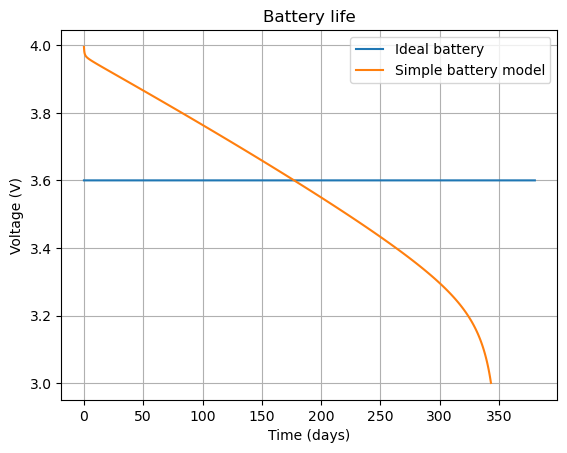

In [12]:
plt.plot(bldf["Time (s)"]/(3600*24), bldf["Voltage (V)"], label="Ideal battery")
plt.plot(bldf2["Time (s)"]/(3600*24), bldf2["Voltage (V)"], label="Simple battery model")
plt.legend()
plt.grid()
plt.title("Battery life")
plt.xlabel("Time (days)")
plt.ylabel("Voltage (V)");

## Battery modelling with PyBaMM
So far, the battery model hasn't included the chemical reactions that occur inside the battery. Such battery models are complex, and the best option for including advanced battery models is to use a battery simulation package. PyBaMM (Python Battery Mathematical Modelling) is an open-source battery simulation package that `sysLoss` can interface with. 

Start by installing PyBaMM.

In [13]:
%pip install pybamm -q
import pybamm

Note: you may need to restart the kernel to use updated packages.


Next we define the two callback functions needed by the *.batt_life()* method. We select the parameter set "Ecker2015" that is a 156mAh battery.

In [14]:
model = pybamm.lithium_ion.DFN()
parameter_values = pybamm.ParameterValues("Ecker2015") # 156mAh model
parameter_values.update({"Current function [A]": "[input]"})
sim = pybamm.Simulation(model, parameter_values=parameter_values)
sim.step(1e-6, inputs={"Current function [A]":0.0}) # dummy step to initialize variables

def probe_pb():
    sol = sim.solution
    cap = parameter_values["Nominal cell capacity [A.h]"]
    return (cap - sol["Discharge capacity [A.h]"].entries[-1], sol["Voltage [V]"].entries[-1], sol["Local ECM resistance [Ohm]"].entries[-1])

def deplete_pb(t, curr):
    sim.step(t, solver=pybamm.CasadiSolver(mode="fast"), inputs={"Current function [A]":curr})
    return probe()

If we tried *.batt_life()* with these callback functions and the Bluetooh sensor system, the simulation would take extremely long and probably fail. PyBaMM is not really made for year-long simulations, the default discharge rate is 1C. So, for a battery that would deplete in a matter of hours or perhaps a few days the PyBaMM callbacks could be used directly.

However, we can use the PyBaMM model to obtain voltage and resistance curves, which we can include in the battery class defined previoulsy. Let's run the PyBaMM model with a discharge rate of 0.1C and 0.01C:

In [15]:
cap = parameter_values["Nominal cell capacity [A.h]"]
# 0.1C discharge
sim = pybamm.Simulation(model, parameter_values=parameter_values)
sim.solve([0,40000], initial_soc = 1.0, inputs={"Current function [A]": 0.1*cap})
sol_0c1 = sim.solution
# 0.01C discharge
sim = pybamm.Simulation(model, parameter_values=parameter_values)
sim.solve([0,400000], initial_soc = 1.0, inputs={"Current function [A]": 0.01*cap})
sol_0c01 = sim.solution

At t = 358.477 and h = 9.16157e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 3706.66, , mxstep steps taken before reaching tout.
At t = 1666.25, , mxstep steps taken before reaching tout.


Let's take a look at the battery voltage and resistance curves:

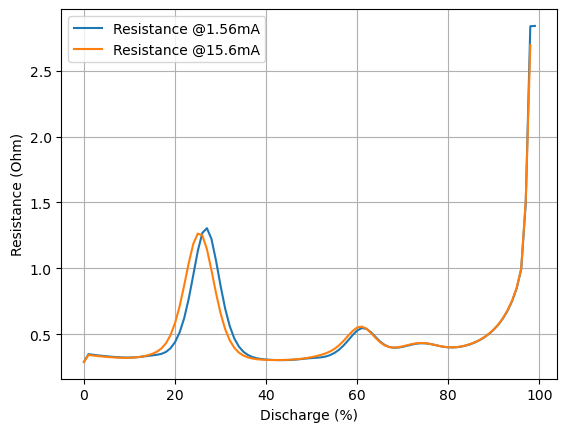

In [16]:
plt.plot(sol_0c01["Local ECM resistance [Ohm]"].entries, label="Resistance @1.56mA")
plt.plot(sol_0c1["Local ECM resistance [Ohm]"].entries, label="Resistance @15.6mA")
plt.xlabel("Discharge (%)")
plt.ylabel("Resistance (Ohm)")
plt.grid()
plt.legend();

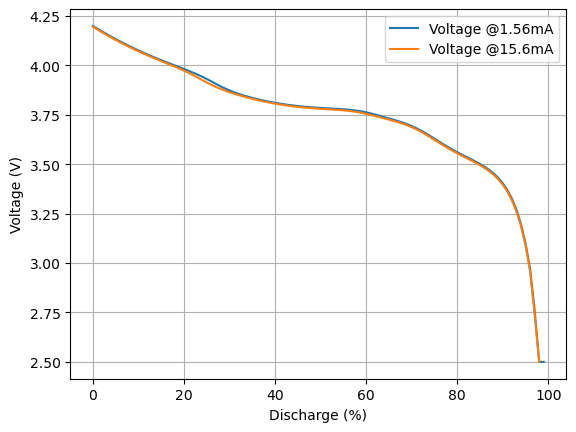

In [17]:
plt.plot(sol_0c01["Voltage [V]"].entries, label="Voltage @1.56mA")
plt.plot(sol_0c1["Voltage [V]"].entries, label="Voltage @15.6mA")
plt.xlabel("Discharge (%)")
plt.ylabel("Voltage (V)")
plt.grid()
plt.legend();

The curves are similar, so the 0.1C curves will be used in the battery class. A new class is made with updated methods for voltage and resistance calculations.

In [18]:
class LiPo2(LiPo):
    def calc_res(self):
        soc = (self.capacity - self.depleted)/self.capacity
        return np.interp(1.0 - soc, self.rs[0], self.rs[1])

    def calc_ocv(self):
        soc = (self.capacity - self.depleted)/self.capacity
        return np.interp(1.0 - soc, self.nom_volt[0], self.nom_volt[1])

Finally run *.batt_life()* with the updated battery class:

In [19]:
x = np.linspace(0.0, 1.0, 99, endpoint=True)
frx = sol_0c1["Local ECM resistance [Ohm]"].entries
fvx = sol_0c1["Voltage [V]"].entries
batt2 = LiPo2(cap, (x, fvx), (x, frx), 3.0)
bldf3 = bts.batt_life("LiPo battery", cutoff=3.0, pfunc=batt2.probe, dfunc=batt2.deplete)

Battery depletion (mAh):   0%|          | 0.00/156 [00:00<?, ?mAh/s]

In [20]:
int(bldf3["Time (s)"].values[-1]/(24*3600))

364

The battery life estimate is now 364 days, somewhat in the middle of the two previous estimates. Let's look at the battery voltage for the three battery models:

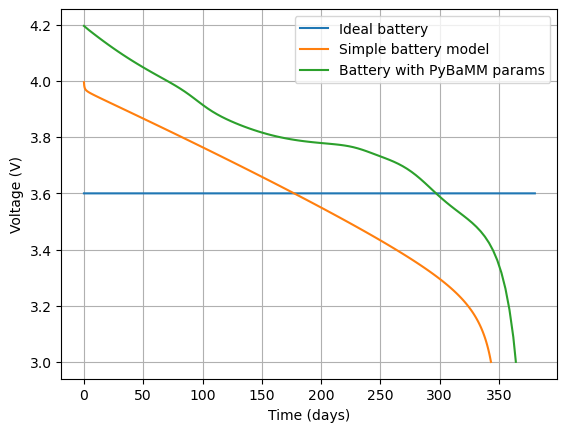

In [21]:
plt.plot(bldf["Time (s)"]/(3600*24), bldf["Voltage (V)"], label="Ideal battery")
plt.plot(bldf2["Time (s)"]/(3600*24), bldf2["Voltage (V)"], label="Simple battery model")
plt.plot(bldf3["Time (s)"]/(3600*24), bldf3["Voltage (V)"], label="Battery with PyBaMM params")
plt.legend()
plt.grid()
plt.xlabel("Time (days)")
plt.ylabel("Voltage (V)");

## Improve battery life
The current design will last for about a year. How can we improve the design to get longer battery life? Start by examining the energy consumed in each phase. 

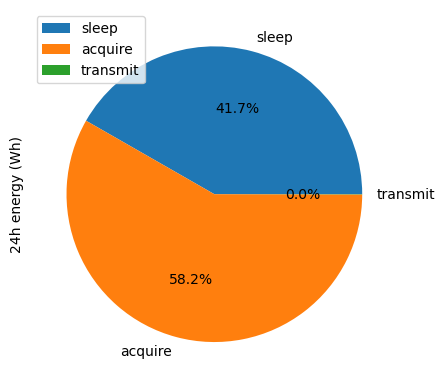

In [22]:
bdf = bts.solve(energy=True)
bdf[bdf.Component == "System total"].plot.pie(y="24h energy (Wh)", labels=bdf.Phase.unique(), autopct='%1.1f%%');

The *acquire* phase consumes the most energy. Let's say it is acceptable to increase the sensor reading interval from 2 hours to 4 hours. That will save some energy - and now it is the *sleep* phase that consumes the most energy.

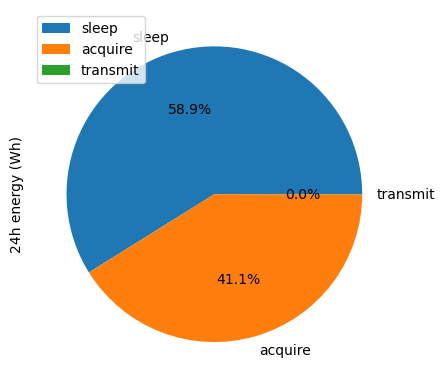

In [23]:
bts_phases = {"sleep": 7200, "acquire": 2.5, "transmit": 2e-3}
bts.set_sys_phases(bts_phases)
bdf2 = bts.solve(energy=True)
bdf2[bdf2.Component == "System total"].plot.pie(y="24h energy (Wh)", labels=bdf2.Phase.unique(), autopct='%1.1f%%');

In [24]:
batt2 = LiPo2(cap, (x, fvx), (x, frx), 3.0)
bldf4 = bts.batt_life("LiPo battery", cutoff=3.0, pfunc=batt2.probe, dfunc=batt2.deplete)

Battery depletion (mAh):   0%|          | 0.00/156 [00:00<?, ?mAh/s]

Battery life has been extended to about 500 days by increasing the sensor reading interval to 4 hours.

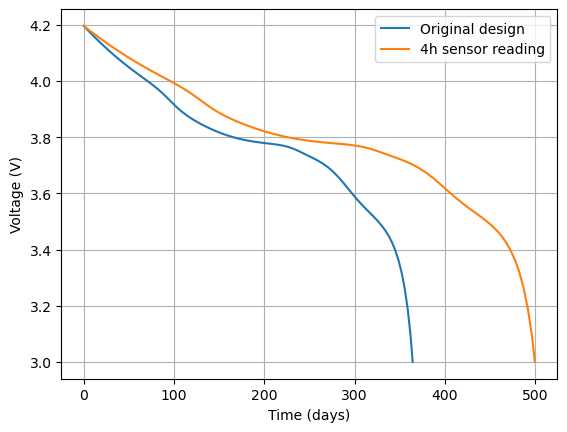

In [25]:
plt.plot(bldf3["Time (s)"]/(3600*24), bldf3["Voltage (V)"], label="Original design")
plt.plot(bldf4["Time (s)"]/(3600*24), bldf4["Voltage (V)"], label="4h sensor reading")
plt.legend()
plt.grid()
plt.xlabel("Time (days)")
plt.ylabel("Voltage (V)");

To address the energy consumption in the *sleep* phase, we could maybe shut down all peripherals in the MCU except for the timer and enable a deep sleep mode. Let's say this reduces the MCU power from 12uW to 0.85uW.

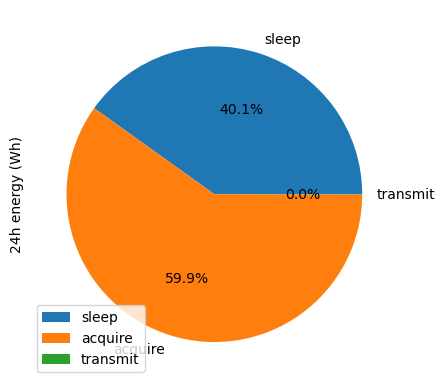

In [26]:
mcu_pwr = {"sleep": 0.85e-6, "acquire": 15e-3, "transmit": 35e-3}
bts.set_comp_phases("MCU", phase_conf=mcu_pwr)
bdf3 = bts.solve(energy=True)
bdf3[bdf3.Component == "System total"].plot.pie(y="24h energy (Wh)", labels=bdf3.Phase.unique(), autopct='%1.1f%%');

In [27]:
batt2 = LiPo2(cap, (x, fvx), (x, frx), 3.0)
bldf5 = bts.batt_life("LiPo battery", cutoff=3.0, pfunc=batt2.probe, dfunc=batt2.deplete)

Battery depletion (mAh):   0%|          | 0.00/156 [00:00<?, ?mAh/s]

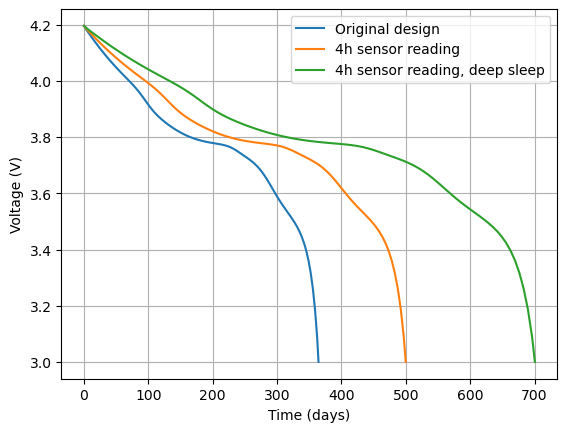

In [28]:
plt.plot(bldf3["Time (s)"]/(3600*24), bldf3["Voltage (V)"], label="Original design")
plt.plot(bldf4["Time (s)"]/(3600*24), bldf4["Voltage (V)"], label="4h sensor reading")
plt.plot(bldf5["Time (s)"]/(3600*24), bldf5["Voltage (V)"], label="4h sensor reading, deep sleep")
plt.legend()
plt.legend()
plt.grid()
plt.xlabel("Time (days)")
plt.ylabel("Voltage (V)");

The battery life has now been extended to almost 700 days - quite an improvement. 

## Summary
This tutorial explores the *.batt_life()* method in `sysLoss` for estimating battery life of the Bluetooth sensor system. Using callback functions `sysLoss` can integrate with just about any user supplied battery model, from ideal batteries to advanced chemistry models. `sysLoss` also identifies where the most energy is consumed, which makes system optimization for battery life much simpler.

### References
Python Battery Mathematical Modelling (PyBaMM): {cite}`Sulzer_Python_Battery_Mathematical_2021`